## **Selecting data for ML Use Case 1**

In this notebook, we're delving into the RDD2022 dataset, specifically honing in on annotated images from Japan. Our mission is clear: to process annotation files, visualize annotations on images, and prep the data for further analysis, all with the aim of curating a dataset subset tailored for ML Use Case 1. Our focus? The detection of potholes (label code: D40). Through meticulous exploration, analysis, and evaluation, we're striving to handpick a dataset subset that not only meets but exceeds the requirements of ML Use Case 1, fueling the development of cutting-edge machine learning models for pothole detection.

In [1]:
# Import necessary libraries
import glob
import os
import pandas as pd
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### **1. Set Up Data Paths and Load Data:**


In [2]:
# 1. Set up paths and load data
data_root_dir = "../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/"
nationality = "Japan"
mode = "train"

In [3]:
image_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "images")
annot_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "annotations/xmls") 

# Ensure paths exist
assert os.path.exists(image_destination_path), print("Image path not found")
assert os.path.exists(annot_destination_path), print("Annotation path not found")

In [4]:
# Get list of image and annotation files
image_list = glob.glob(image_destination_path+"/*.jpg")
annot_list = glob.glob(annot_destination_path+"/*.xml")

### **2. Define Label Mapping:**

In [5]:
# 2. Define label map
label_map = {
    "D00": "Liner crack, longitudinal, wheel mark part",
    "D01": "Liner crack, longitudinal, construction joint part",
    "D10": "Liner crack, lateral, equal interval",
    "D11": "Liner crack, lateral, construction joint part",
    "D20": "Alligator crack",
    "D40": "Rutting, bump, pothole, separation",
    "D43": "White line blur",
    "D44": "Cross walk blur"
}

### **3. Read, Parse and Visualize Annotations::**

In [6]:
# 3. Define functions for reading and parsing XML, and drawing bounding boxes
def read_and_parse_xml(xml_file_path):
    """Reads and parses an XML file."""
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    return root

# Function to draw bounding boxes on the image
def draw_bounding_boxes(image_path, annotations):
    """Draws bounding boxes on the image."""
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error loading image {image_path}")
        return

    for obj in annotations.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Draw the bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [7]:
# Path to the XML file
xml_file_path = annot_list[0]

# Path to the image file
image_file_path = image_list[0]

print(xml_file_path)
print(image_file_path)

# Read and parse the XML file
annotations = read_and_parse_xml(xml_file_path)

../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan\Japan\train\annotations/xmls\Japan_000000.xml
../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan\Japan\train\images\Japan_000000.jpg


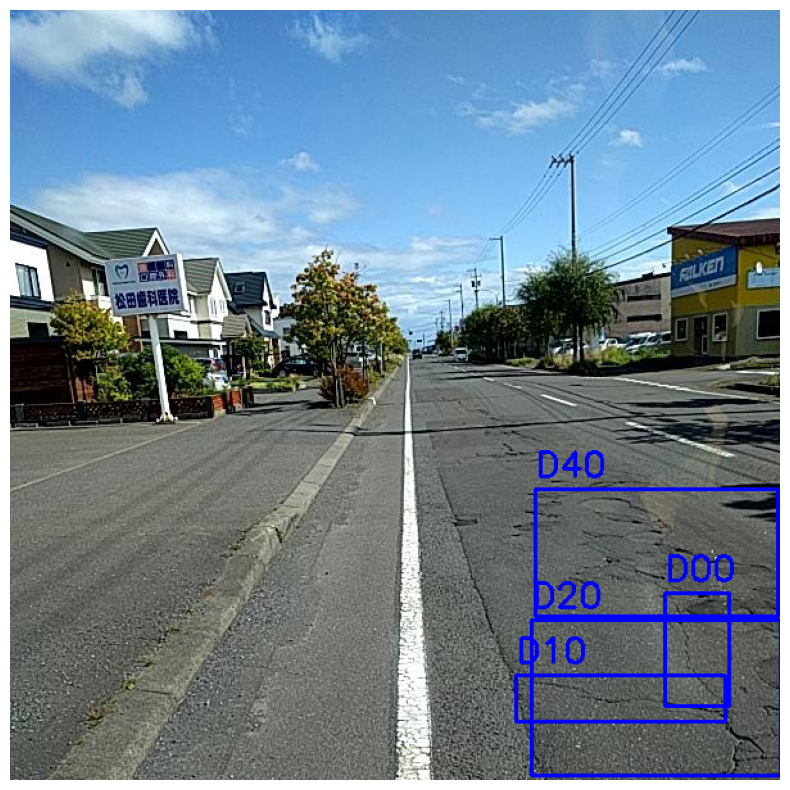

In [8]:
# Draw bounding boxes on the image
draw_bounding_boxes(image_file_path, annotations)

### **4. Process Annotations in Parallel:**

In [9]:
# 4. Functions for filtering annotations and parallel processing

def encoded_obj_annotations(annotations):
    """Encodes object annotations."""
    objects_names = []
    for obj in annotations.findall('object'):
        label_code = obj.find('name').text
        objects_names.append(label_code)
    return objects_names

def process_annotation_file(xml_file_path):
    """Processes a single annotation file."""
    annotations = read_and_parse_xml(os.path.abspath(xml_file_path))
    objects_names = encoded_obj_annotations(annotations)
    return xml_file_path, objects_names

# Function to process all annotation files in parallel and show progress
def process_all_annotations(xml_files):
    """Processes all annotation files in parallel and shows progress."""
    results = []
    with ThreadPoolExecutor(max_workers=20) as executor:
        future_to_xml = {executor.submit(process_annotation_file, xml_file): xml_file for xml_file in xml_files}
        for future in tqdm(as_completed(future_to_xml), total=len(future_to_xml), desc="Processing files"):
            xml_file = future_to_xml[future]
            try:
                xml_file_path, objects_names = future.result()
                results.append((xml_file_path, objects_names))
            except Exception as exc:
                print(f"{xml_file} generated an exception: {exc}")
    return results

In [10]:
annotations = read_and_parse_xml(annot_list[0])
encoded_obj_annotations(annotations)

['D20', 'D40', 'D10', 'D00']

In [11]:
# Process all annotations
results = process_all_annotations(annot_list)

Processing files: 100%|██████████| 10506/10506 [00:01<00:00, 8307.38it/s]


### **6. Create a DataFrame with Encoded Categories:**

In [12]:
# df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])

# Convert the data to a DataFrame
df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])

# Create columns for each label with binary encoding
for label in label_map.keys():
    df[label] = df['objects'].apply(lambda x: x.count(label))

In [13]:
df

,xml_file_path,objects,D00,D01,D10,D11,D20,D40,D43,D44
0,../../project/data/RDD2022_released_through_CR...,"[D44, D00, D20, D10]",1,0,1,0,1,0,0,1
1,../../project/data/RDD2022_released_through_CR...,[],0,0,0,0,0,0,0,0
2,../../project/data/RDD2022_released_through_CR...,[D20],0,0,0,0,1,0,0,0
3,../../project/data/RDD2022_released_through_CR...,[],0,0,0,0,0,0,0,0
4,../../project/data/RDD2022_released_through_CR...,[D44],0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
10501,../../project/data/RDD2022_released_through_CR...,"[D00, D43, D20]",1,0,0,0,1,0,1,0
10502,../../project/data/RDD2022_released_through_CR...,[D00],1,0,0,0,0,0,0,0
10503,../../project/data/RDD2022_released_through_CR...,"[D40, D40]",0,0,0,0,0,2,0,0
10504,../../project/data/RDD2022_released_through_CR...,[D00],1,0,0,0,0,0,0,0


### **7. Selecting D40 samples**

In [14]:
include_labels = {"D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44"}

In [15]:
df_temp = df[df["objects"].apply(lambda x: True if include_labels.intersection(set(x)) else False)]

In [16]:
df_temp

,xml_file_path,objects,D00,D01,D10,D11,D20,D40,D43,D44
0,../../project/data/RDD2022_released_through_CR...,"[D44, D00, D20, D10]",1,0,1,0,1,0,0,1
2,../../project/data/RDD2022_released_through_CR...,[D20],0,0,0,0,1,0,0,0
4,../../project/data/RDD2022_released_through_CR...,[D44],0,0,0,0,0,0,0,1
5,../../project/data/RDD2022_released_through_CR...,[D10],0,0,1,0,0,0,0,0
6,../../project/data/RDD2022_released_through_CR...,[D44],0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
10501,../../project/data/RDD2022_released_through_CR...,"[D00, D43, D20]",1,0,0,0,1,0,1,0
10502,../../project/data/RDD2022_released_through_CR...,[D00],1,0,0,0,0,0,0,0
10503,../../project/data/RDD2022_released_through_CR...,"[D40, D40]",0,0,0,0,0,2,0,0
10504,../../project/data/RDD2022_released_through_CR...,[D00],1,0,0,0,0,0,0,0


In [17]:
def label_targeted_annotations(data_root_dir, nationality, include_labels, mode="train"):
    
    annot_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "annotations/xmls") 
    assert os.path.exists(annot_destination_path), print("Annotation path not found")
    annot_list = glob.glob(annot_destination_path+"/*.xml")
    results = process_all_annotations(annot_list)
    # Convert the data to a DataFrame
    df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])
    # Create columns for each label with binary encoding
    for label in label_map.keys():
        df[label] = df['objects'].apply(lambda x: x.count(label))
    # df_temp = df[df["objects"].apply(lambda x: True if include_labels.intersection(set(x)) else False)]
    df["nationality"] = nationality
    return df

In [18]:
label_targeted_annotations(data_root_dir, "United_States", include_labels)

Processing files: 100%|██████████| 4805/4805 [00:07<00:00, 628.82it/s]


,xml_file_path,objects,D00,D01,D10,D11,D20,D40,D43,D44,nationality
0,../../project/data/RDD2022_released_through_CR...,"[D00, D00, D00, D00]",4,0,0,0,0,0,0,0,United_States
1,../../project/data/RDD2022_released_through_CR...,"[D10, D00]",1,0,1,0,0,0,0,0,United_States
2,../../project/data/RDD2022_released_through_CR...,[D10],0,0,1,0,0,0,0,0,United_States
3,../../project/data/RDD2022_released_through_CR...,[D10],0,0,1,0,0,0,0,0,United_States
4,../../project/data/RDD2022_released_through_CR...,[D00],1,0,0,0,0,0,0,0,United_States
...,...,...,...,...,...,...,...,...,...,...,...
4800,../../project/data/RDD2022_released_through_CR...,[D10],0,0,1,0,0,0,0,0,United_States
4801,../../project/data/RDD2022_released_through_CR...,"[D00, D00, D10]",2,0,1,0,0,0,0,0,United_States
4802,../../project/data/RDD2022_released_through_CR...,"[D10, D00, D00]",2,0,1,0,0,0,0,0,United_States
4803,../../project/data/RDD2022_released_through_CR...,[D10],0,0,1,0,0,0,0,0,United_States


### **8. Initial Analysis**

In [19]:
nationality_list = [i for i in os.listdir("../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/") if not i.endswith(".zip")]

In [20]:
df_list = []
for nation in nationality_list:
    results = label_targeted_annotations(data_root_dir, nation, include_labels)
    df_list.append(results)

Processing files: 100%|██████████| 4805/4805 [00:00<00:00, 6251.16it/s]


In [21]:
df_comb = pd.concat(df_list)

In [22]:
df_comb[["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44"]].sum()

D00    26016
D01      179
D10    11830
D11       45
D20    10617
D40     6544
D43      793
D44     5057
dtype: int64

In [23]:
df_comb[["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44","nationality"]].groupby("nationality").sum()

,D00,D01,D10,D11,D20,D40,D43,D44
nationality,,,,,,,,
China_Drone,1426,0,1263,0,293,86,0,0
China_MotorBike,2678,0,1096,0,641,235,0,0
Czech,988,0,399,0,161,197,0,0
India,1555,179,68,45,2021,3187,57,1062
Japan,4049,0,3979,0,6199,2243,736,3995
Norway,8570,0,1730,0,468,461,0,0
United_States,6750,0,3295,0,834,135,0,0


In [24]:
df_comb[["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44","nationality"]].groupby("nationality").mean().round(4)

,D00,D01,D10,D11,D20,D40,D43,D44
nationality,,,,,,,,
China_Drone,0.5939,0.0000,0.5260,0.0000,0.1220,0.0358,0.0000,0.0000
China_MotorBike,1.3546,0.0000,0.5544,0.0000,0.3242,0.1189,0.0000,0.0000
Czech,0.3492,0.0000,0.1410,0.0000,0.0569,0.0696,0.0000,0.0000
India,0.2018,0.0232,0.0088,0.0058,0.2623,0.4136,0.0074,0.1378
Japan,0.3854,0.0000,0.3787,0.0000,0.5900,0.2135,0.0701,0.3803
Norway,1.0501,0.0000,0.2120,0.0000,0.0573,0.0565,0.0000,0.0000
United_States,1.4048,0.0000,0.6857,0.0000,0.1736,0.0281,0.0000,0.0000


In [25]:
nationality_list

['China_Drone',
 'China_MotorBike',
 'Czech',
 'India',
 'Japan',
 'Norway',
 'United_States']